<a href="https://colab.research.google.com/github/LaunaG/jobs-recommender/blob/launa_data_analysis/Job%20Recommender%20System%20-%20Matrix%20Factorization%20-%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering

### **Import Required Libraries**

In [1]:
# Libraries for loading data into Google Colab
import glob
import gzip
import os
import requests
import zipfile

from google.colab import drive, files

In [2]:
# Libraries for data processing
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt

from sklearn.decomposition import NMF
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
from IPython.display import HTML

### **Configure Display Settings**

In [3]:
%matplotlib notebook

### **Import Files**

The data is sourced from CareerBuilder.com's [Job Recommendation Challenge](https://www.kaggle.com/c/job-recommendation/data), hosted on Kaggle in 2012.

**Load Datasets into Local Colab Storage (If Applicable)**


*Technical Notes:*
 
*   Because the files are large, this cell takes a few minutes to run (< 5 minutes).

*   Unfortunately, data does not persist in the local storage system between sessions, so you have to rerun this cell from time to time.

In [4]:
# If data files are not already in local storage
if not os.path.isdir("data"):

  # Retrieve zip file from Dropbox and write to base/default folder
  r = requests.get("https://www.dropbox.com/s/v2fdobitjrjieku/data.zip?dl=1")
  with open("data.zip", 'wb') as f:
      f.write(r.content)

  # Extract zip file contents to create local data folder with .tsv.gz files
  with zipfile.ZipFile("data.zip", 'r') as zip_ref:
      zip_ref.extractall(".")

  # For each unzipped file path
  for path in glob.glob("data/*.tsv.gz"):

    # Create destination file path
    dest_path = f'data/{os.path.basename(path)[:-3]}'

    # Open unzipped file for reading and destination file for writing
    with open(path, 'rb') as f:
      with open(dest_path, 'wb') as g:

            # Decompress unzipped file data and write to destination
            decompressed = gzip.decompress(f.read())
            g.write(decompressed)

    # Delete original compressed file
    os.remove(path)

  # Delete zip file
  os.remove("data.zip")

**Users**

*users.tsv - Holds all users and their metadata*

In [5]:
# File Preview
users = pd.read_csv("data/users.tsv", sep="\t")
users.head(5)

UserID  WindowID  Split  ... CurrentlyEmployed ManagedOthers ManagedHowMany
0      47         1  Train  ...               Yes            No              0
1      72         1  Train  ...               Yes            No              0
2      80         1  Train  ...               Yes           Yes              5
3      98         1  Train  ...               Yes            No              0
4     123         1  Train  ...               Yes            No              0

[5 rows x 15 columns]

**Jobs**

*jobs.tsv: Holds the jobs available on CareerBuilder.com during a 13-day window*

In [6]:
# File preview for jobs listed in the first of the seven windows
jobs1 = pd.read_csv("data/jobs1.tsv", sep="\t", error_bad_lines=False)
jobs1.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


JobID  WindowID  ...                StartDate              EndDate
0      1         1  ...  2012-03-07 13:17:01.643  2012-04-06 23:59:59
1      4         1  ...  2012-03-21 02:03:44.137  2012-04-20 23:59:59
2      7         1  ...  2012-03-02 16:36:55.447  2012-04-01 23:59:59
3      8         1  ...  2012-03-03 09:01:10.077  2012-04-02 23:59:59
4      9         1  ...   2012-03-03 09:01:11.88  2012-04-02 23:59:59

[5 rows x 11 columns]

**Apps**

*apps.tsv: Holds the applications users submitted*

In [7]:
# File preview
apps = pd.read_csv("data/apps.tsv", sep="\t")
apps.head(5)

UserID  WindowID  Split          ApplicationDate   JobID
0      47         1  Train  2012-04-04 15:56:23.537  169528
1      47         1  Train  2012-04-06 01:03:00.003  284009
2      47         1  Train  2012-04-05 02:40:27.753    2121
3      47         1  Train  2012-04-05 02:37:02.673  848187
4      47         1  Train  2012-04-05 22:44:06.653  733748

### Create Matrix

**Filter Data to Include Window 1 Only**

In [8]:
# Filter users, jobs, and applications to include only those assigned to first window and then retrieve and sort ids
window1_app_ids = apps.query("WindowID == 1")[["UserID", "JobID"]]
window1_user_ids = users.query("WindowID == 1")["UserID"].sort_values().tolist()
window1_job_ids = jobs1["JobID"].sort_values().tolist()

# Determine data counts
window1_num_apps = len(window1_app_ids)
window1_num_users = len(window1_user_ids)
window1_num_jobs = len(window1_job_ids)
print(f'''The first window had:\n
    - {window1_num_jobs:,} open job listings
    - {window1_num_users:,} active users
    - {window1_num_apps:,} apps submitted by active users to a subset of those jobs''')

The first window had:

    - 285,155 open job listings
    - 77,060 active users
    - 353,582 apps submitted by active users to a subset of those jobs


**Prepare Row and Column Data for Matrix**

In [9]:
# Create id-index lookups
window1_user_lookup = {val: idx for idx, val in enumerate(window1_user_ids)}
window1_job_lookup = {val: idx for idx, val in enumerate(window1_job_ids)}

# Initialize values for CSR ("Compressed Sparse Row") matrix
data = [1] * len(window1_app_ids)
rows = window1_app_ids["UserID"].apply(lambda id: window1_user_lookup[id]).tolist()
columns = window1_app_ids["JobID"].apply(lambda id: window1_job_lookup[id]).tolist()

**Create Matrix**

In [10]:
# Create CSR matrix
# For background on the use of sparse matrices, please see:
# https://towardsdatascience.com/why-we-use-sparse-matrices-for-recommender-systems-2ccc9ab698a4

csr = csr_matrix(
    arg1=(data, (rows, columns)),
    shape=(window1_num_users, window1_num_jobs), 
    dtype=np.int8)

**Preview Matrix (Scroll Down to See Figure)**

<IPython.core.display.Javascript object>


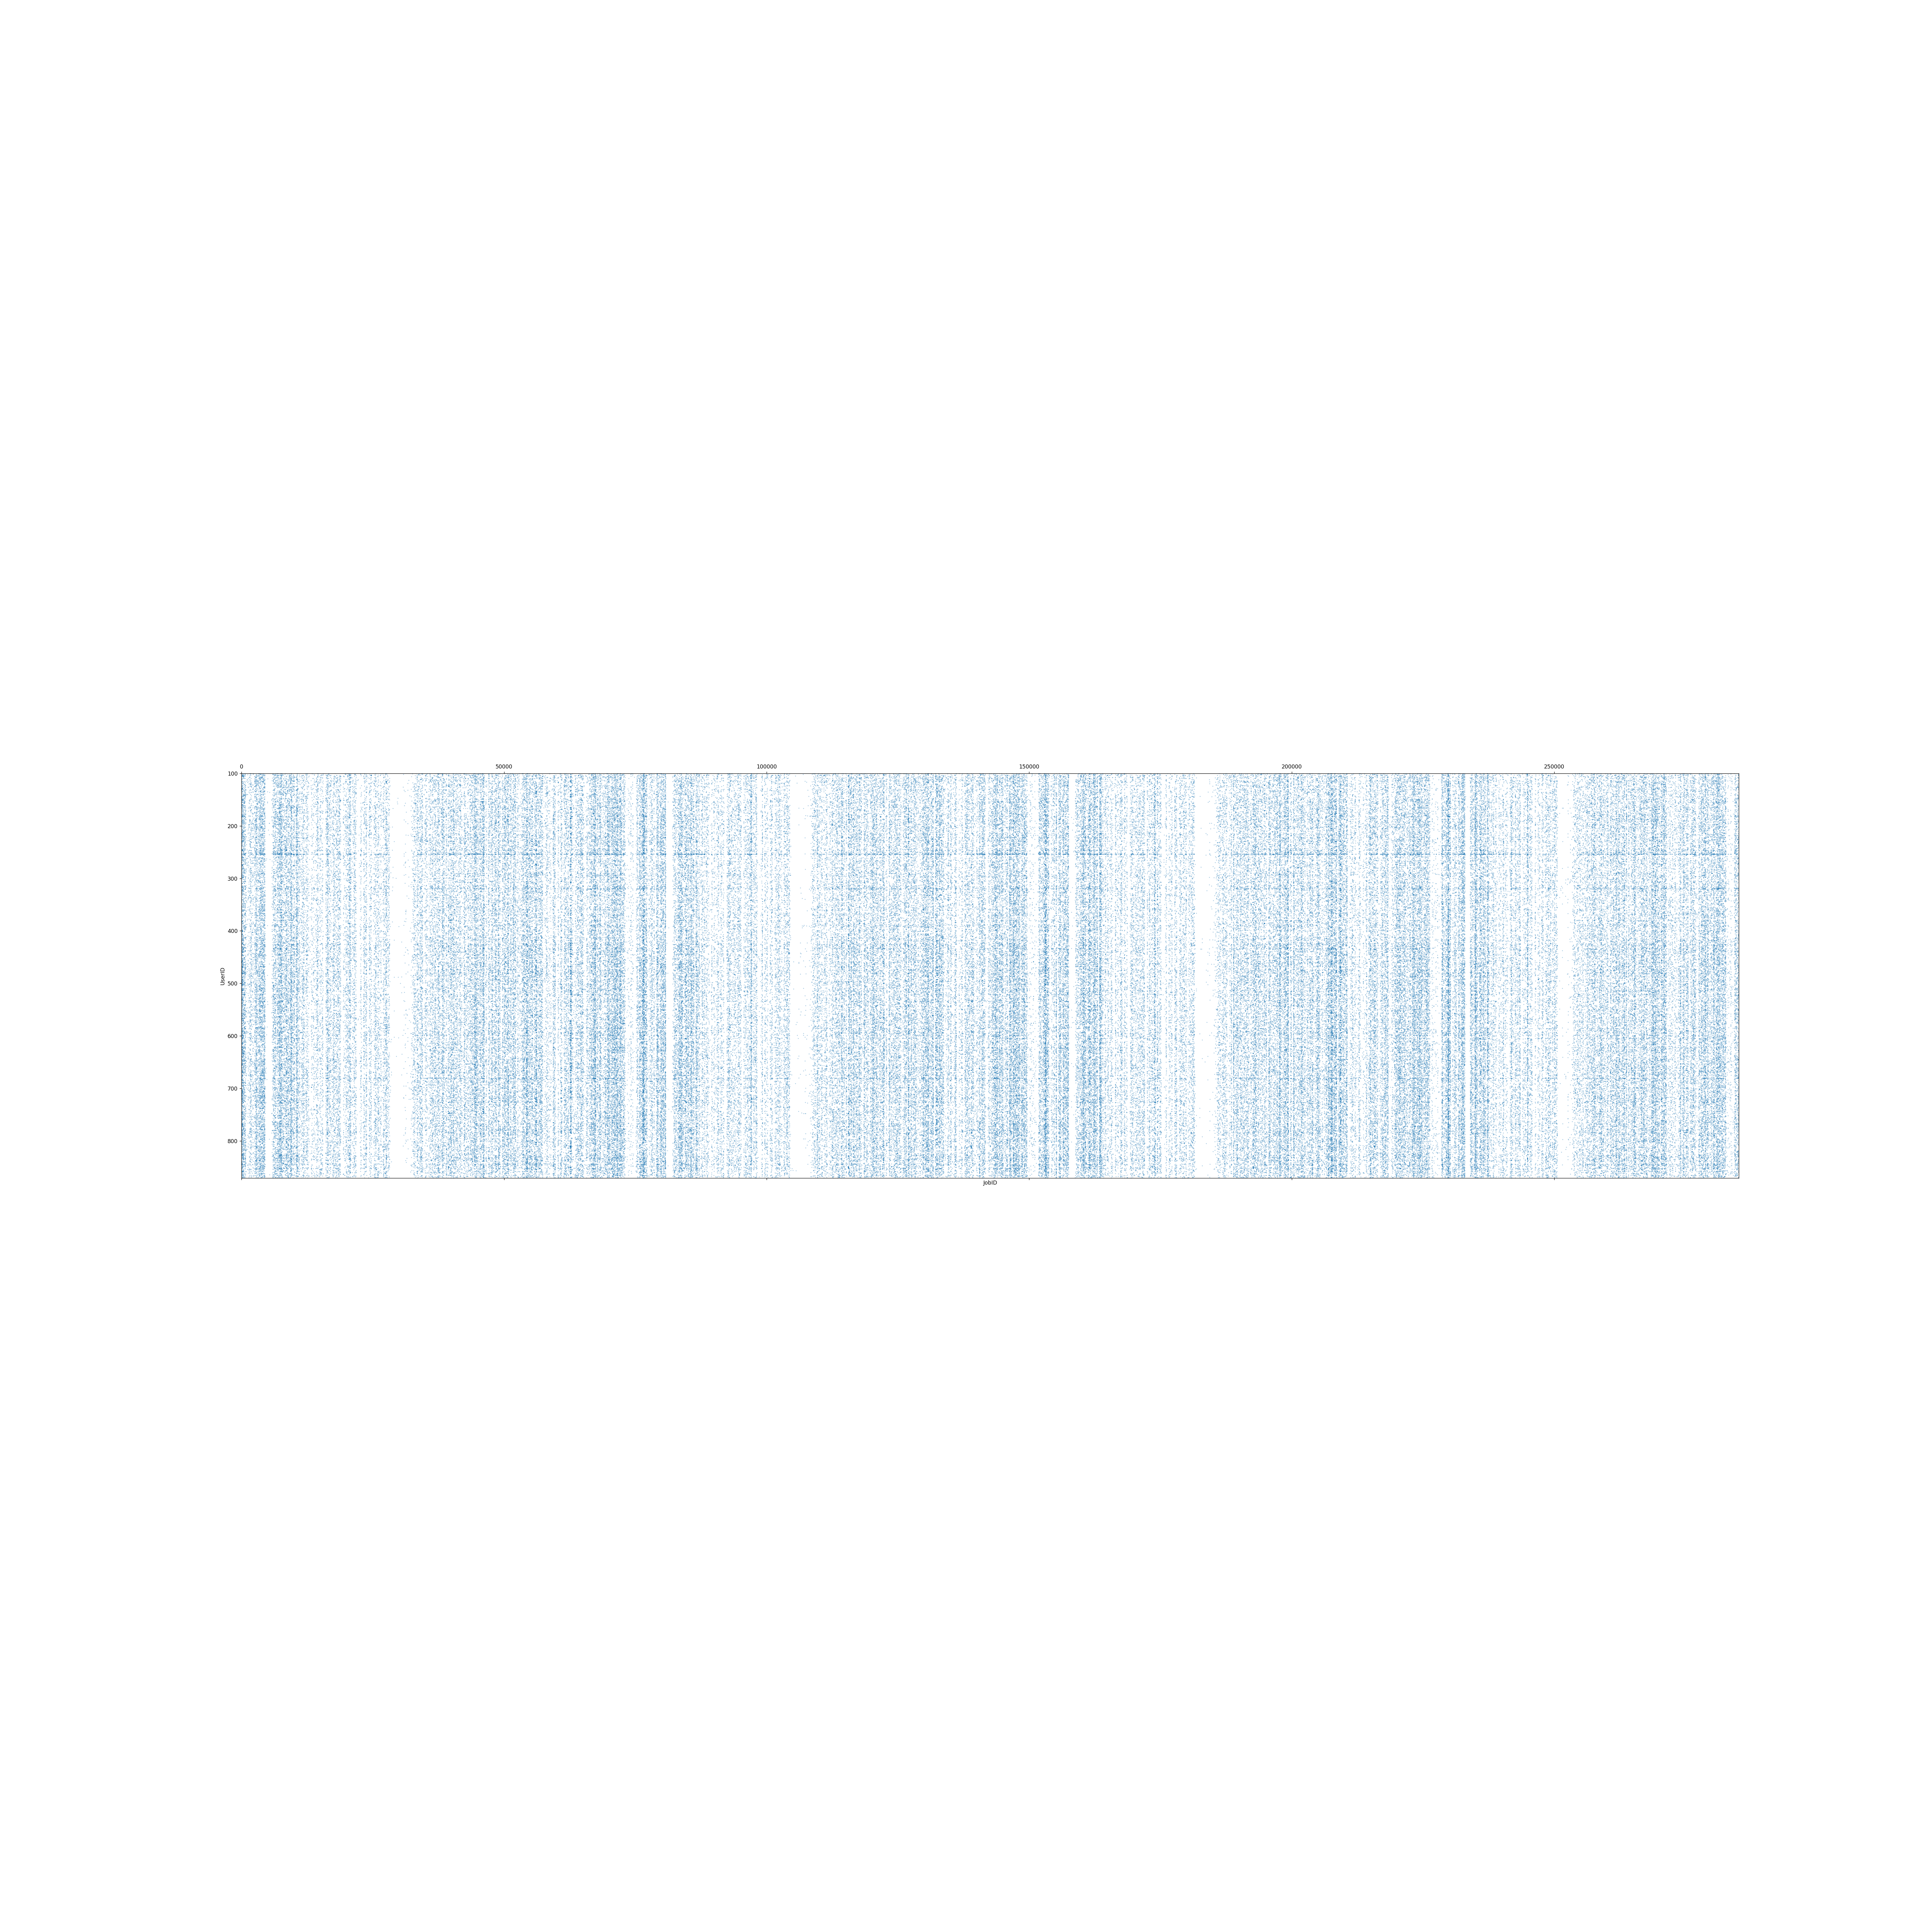

In [ ]:
# Preview first several hundred rows
fig = plt.figure(figsize=(50, 50))
tick_range = np.arange(0, 80000, 100)
plt.yticks(tick_range, list(tick_range))

plt.xlabel("JobID")
plt.ylabel("UserID")

display(HTML("<h4>CSR Matrix Preview</h4>"))
plt.spy(csr, markersize = 0.1, origin="lower")

# Note: There is a lot of whitespace around the figure, but you can view it by scrolling down.
# You can also zoom in by scrolling to the bottom left corner of the screen and selecting the square button.

### Apply Non-Negative Matrix Factorization (NMF)

**Outstanding Questions**

How does the sklearn library's NMF implementation compare to others?
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- https://github.com/benfred/implicit

How should we divide the data to perform cross validation?  Some references:  

- https://towardsdatascience.com/how-to-use-cross-validation-for-matrix-completion-2b14103d2c4c
- http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/
- https://jessesw.com/Rec-System/
- https://arxiv.org/pdf/0909.3052.pdf
- https://stats.stackexchange.com/questions/111205/how-to-choose-an-optimal-number-of-latent-factors-in-non-negative-matrix-factori
- https://pdfs.semanticscholar.org/0265/769b0fbf86bb0e700573c80e388bb54c3f7a.pdf

What metric should we use for accuracy?

 - http://fastml.com/evaluating-recommender-systems/
 - https://stackoverflow.com/questions/7410030/how-to-check-my-item-based-collaborative-filtering-algo-is-correct

Fairness Paper:
- https://proceedings.neurips.cc/paper/2017/file/e6384711491713d29bc63fc5eeb5ba4f-Paper.pdf

Other Helpful Links:

General Recommender Systems
- https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a
- https://www.prem-melville.com/publications/recommender-systems-eml2010.pdf
- https://realpython.com/build-recommendation-engine-collaborative-filtering/

NMF

- https://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/
- https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c
- http://www.billconnelly.net/?p=534
- https://www.slideshare.net/BenjaminBengfort/non-negative-matrix-factorization
- https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
- https://arxiv.org/pdf/1401.5226.pdf

In [ ]:
def perform_nmf(k):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(csr)
    H = model.components_
    return model.reconstruction_err_

In [ ]:
# Note - Matrix Factorization for k = 2:

# CSR Matrix
# ------------
# csr.shape
# (77060, 285155)

# User-Related Aspect
# ------------
# W.shape
# (77060, 2)

# Job-Related Aspect
# ------------
# H.shape
# (2, 285155)

#### Experimentation/Scratchwork

In [ ]:
k_values = [k for k in range(1, 30)]
reconstruction_errors = []
for k in k_values:
    reconstruction_errors.append(perform_nmf(k))

In [ ]:
reconstruction_errors

[592.3884221740352,
 590.8530285046623,
 589.338703353567,
 588.0957420889573,
 586.9706550997719,
 585.7375877530601,
 584.6683782660656,
 583.5931984723173,
 582.7018847537063,
 581.8595370575538,
 581.0536509855931,
 580.3211842746466,
 579.5229514365626,
 579.2998802791661,
 578.3646400185828,
 577.7418128630284,
 577.1416355283638,
 576.464700677454,
 575.9512546514391,
 575.1968910663398,
 574.70257497319,
 574.3264360056518,
 574.0547504154971,
 573.537609957429,
 572.9247030180313,
 572.5056059597265,
 572.2861022593443,
 571.9009433284248,
 571.4510233907744]

In [ ]:
%matplotlib inline

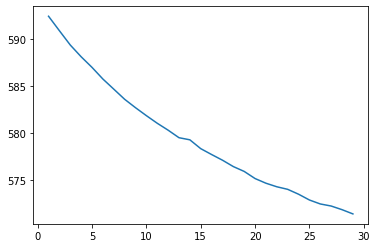

In [ ]:
plt.plot(k_values, reconstruction_errors)

In [ ]:
k_values2 = [k for k in range(30, 60)]
reconstruction_errors2 = []
for k in k_values2:
    reconstruction_errors2.append(perform_nmf(k))

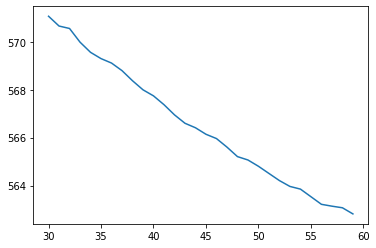

In [ ]:
plt.plot(k_values2, reconstruction_errors2)

In [ ]:
reconstruction_errors2

[571.0741618847792,
 570.6648768387506,
 570.562694975297,
 569.9910002046591,
 569.565955933638,
 569.3037271749973,
 569.1175817246573,
 568.8007742498626,
 568.3786700709512,
 567.9993986158073,
 567.746527113346,
 567.3777884766429,
 566.9530570691661,
 566.6010469310556,
 566.4133103924901,
 566.1415618344619,
 565.9622407323448,
 565.604785608744,
 565.2078442253548,
 565.0664753272672,
 564.8038931578765,
 564.5041764994289,
 564.2056835891676,
 563.9614168501031,
 563.8498772333139,
 563.5322484426673,
 563.2139525163673,
 563.1366773661955,
 563.0696671024677,
 562.8129175797911]